In [1]:
import copy
import random
import math
import time
import pickle
import pprint

import tqdm

import numpy
import pandas

import sklearn
import sklearn.metrics
import sklearn.svm

import xgboost

import matplotlib
import matplotlib.pyplot
import seaborn

# Utility functions

In [2]:
def equal_pdf(size):
    return numpy.ones((size,)) / size

In [3]:
def normalize_pdf(x):
    x = x / x.sum()
    x = numpy.nan_to_num(x, copy=True, nan=0.0, posinf=None, neginf=None)
    if x.sum() == 0.:
        x = equal_pdf(x.shape[0])
    return x

In [4]:
def get_k_accuracy_for_target(x, target):
    x = pandas.Series(x).sort_values(ascending=False).reset_index()
    return x[x['index']==target].index[0] + len(x[x[0]==x[x['index']==target].iloc[0][0]].index)/2

In [5]:
def target_pdf(size, target):
    x = numpy.zeros((size,))
    x[target] = 1
    return x

# Opinion pools

In [6]:
def majority_vote(X):
    votes = X.argmax(axis=1)
    vote = pandas.Series(votes).value_counts().sort_index().idxmax()
    return target_pdf(X.shape[1], vote)

In [7]:
def linear_opinion_pool(X):
    x = X.sum(axis=0)
    return normalize_pdf(x)

In [8]:
def logarithmic_opinion_pool(X):
    x = X.prod(axis=0)
    return normalize_pdf(x)

In [9]:
def paired_opinion_pool(X, pool1, pool2):
    Y = []
    for i in range(X.shape[0]):
        for j in range(i+1, X.shape[0]):
            Y.append(pool1(numpy.array([X[i, :], X[j, :]])))
    Y = numpy.array(Y)
    return pool2(Y)

In [10]:
class PairedOpinionPool:
    def __init__(self, pool1, pool2):
        self.pool1 = pool1
        self.pool2 = pool2
        
    def __call__(self, X):
        return paired_opinion_pool(X, self.pool1, self.pool2)

In [11]:
logarithmic_linear_opinion_pool = PairedOpinionPool(logarithmic_opinion_pool, linear_opinion_pool)

# Configuration

In [12]:
# 100000
EXPERIMENT_SIZE = 100000
ROLLING_WINDOW_SIZE = EXPERIMENT_SIZE//10
# 128
ACTORS = 3
# 8
FEATURES = 3

# 0.1
BASE_ACTIVITY = 0.1
BASE_STD = 1/ACTORS

ACTIVITY_SHIFT_STD = 1e-2
MEAN_SHIFT_STD = 1e-2
STD_SHIFT_STD = 1e-2

TRAIN_SIZE = 0.5

PROB_FALSE_FLAG = 0.4

MODELS = {
    # 'Naive Bayes': sklearn.naive_bayes.GaussianNB(),
    'Linear SVM': sklearn.svm.SVC(kernel='linear', probability=True),
    # 'SVM with RBF': sklearn.svm.SVC(probability=True),
    # 'MLP': sklearn.neural_network.MLPClassifier(early_stopping=True),
    'XGBoost': xgboost.XGBClassifier(n_estimators=1000, n_jobs=1, objective='multi_softmax')
}
MODEL = MODELS['Linear SVM']

FIGSIZE = (8, 4)

In [13]:
pools = {
    # 'Majority Vote': majority_vote, 
    'Linear Opinion Pool': linear_opinion_pool, 
    'Logarithmic Opinion Pool': logarithmic_opinion_pool,
    'Pairing Aggregator': logarithmic_linear_opinion_pool,
}

# Experiment

In [14]:
feature_names = [f'x{i}' for i in range(FEATURES)]

## Prepare dataset

In [15]:
columns = [
    'Name',
    'start',
    'end',
    'activity',
]

for i in range(FEATURES):
    columns.append(f'x{i}_mean')
    columns.append(f'x{i}_std')

df_actors = pandas.DataFrame(columns=columns)

for i in range(ACTORS):
    start = random.uniform(0, EXPERIMENT_SIZE * (TRAIN_SIZE - 0.1))
    end = random.uniform(EXPERIMENT_SIZE * (TRAIN_SIZE + 0.1), EXPERIMENT_SIZE)

    values = [
        'APT'+str(i),
        start,
        end,
        random.uniform(0.0001, BASE_ACTIVITY),
    ]
    for _ in range(FEATURES):
        values.append(random.uniform(-1, 1))
        values.append(random.uniform(0, BASE_STD))

    df_actors.loc[i] = pandas.Series(
        values,
        index=df_actors.columns,
        name=i,
    )


In [16]:
df_actors

,Name,start,end,activity,x0_mean,x0_std,x1_mean,x1_std,x2_mean,x2_std
0,APT0,34400.027497,99232.401041,0.05293,0.616601,0.127307,-0.995215,0.307068,-0.218063,0.045395
1,APT1,9243.730191,87094.169063,0.083828,0.518659,0.290513,-0.226985,0.270489,0.22577,0.209123
2,APT2,35951.65766,81759.618103,0.053876,-0.12686,0.132722,-0.277634,0.267092,0.705371,0.114815


In [17]:
columns = [
    'Name',
    'Timestep',
] + feature_names

df_incidents = pandas.DataFrame(columns=columns)

incident_i = 0
for i in tqdm.tqdm(range(EXPERIMENT_SIZE)):
    for j in range(ACTORS):
        if df_actors.iloc[j]['start'] <= i and df_actors.iloc[j]['end'] >= i and random.uniform(0, 1) < df_actors.iloc[j]['activity']:
            feature_values = [
                random.normalvariate(
                    df_actors.iloc[j][f'x{k}_mean'], df_actors.iloc[j][f'x{k}_std']
                )
                for k in range(FEATURES)
            ]

            # If generating test data already, introduce false flags corresponding to a sample from another actor present in the training data
            if i > EXPERIMENT_SIZE * TRAIN_SIZE:
                # if len(df_incidents[(df_incidents['Name'] != df_actors.iloc[j]['Name'])].index) > 0:
                blamed_actor = df_incidents[
                    (df_incidents['Name'] != df_actors.iloc[j]['Name'])
                    & (df_incidents['Timestep'] < EXPERIMENT_SIZE * TRAIN_SIZE)
                ]['Name'].sample(1).iloc[0]
                for k in range(FEATURES):
                    if random.uniform(0, 1) < PROB_FALSE_FLAG:
                        feature_values[k] = df_incidents[
                            (df_incidents['Name'] == blamed_actor)
                            & (df_incidents['Timestep'] < EXPERIMENT_SIZE * TRAIN_SIZE)
                        ][f'x{k}'].sample(1).iloc[0]

            values = [
                df_actors.iloc[j]['Name'],
                i,
            ] + feature_values

            series_index = str(i)+str(',')+str(j)

            df_incidents.loc[series_index] = pandas.Series(
                values,
                index=df_incidents.columns,
                name=series_index,
            )
            incident_i += 1

    for k in range(FEATURES):
        df_actors.loc[j, 'activity'] = min(
            max(
                df_actors.loc[j, 'activity'] +
                random.normalvariate(0, ACTIVITY_SHIFT_STD),
                0
            ),
            BASE_ACTIVITY
        )

        df_actors.loc[j, f'x{k}_mean'] = min(
            max(
                df_actors.loc[j, f'x{k}_mean'] +
                random.normalvariate(0, MEAN_SHIFT_STD),
                -1
            ),
            1
        )

        df_actors.loc[j, f'x{k}_std'] = min(
            max(
                df_actors.loc[j, f'x{k}_std'] +
                random.normalvariate(0, STD_SHIFT_STD),
                0
            ),
            BASE_STD
        )

    if i % 1000 == 0:
        df_incidents = df_incidents.copy()
0

  0%|          | 154/100000 [00:00<01:04, 1536.37it/s]

100%|██████████| 100000/100000 [01:46<00:00, 939.89it/s]


0

In [18]:
df_actors

,Name,start,end,activity,x0_mean,x0_std,x1_mean,x1_std,x2_mean,x2_std
0,APT0,34400.027497,99232.401041,0.05293,0.616601,0.127307,-0.995215,0.307068,-0.218063,0.045395
1,APT1,9243.730191,87094.169063,0.083828,0.518659,0.290513,-0.226985,0.270489,0.22577,0.209123
2,APT2,35951.65766,81759.618103,0.023797,-0.759649,0.282624,0.62864,0.00722,0.049739,0.215013


In [19]:
df_incidents

,Name,Timestep,x0,x1,x2
"9276,1",APT1,9276,0.514415,-0.356119,0.147344
"9289,1",APT1,9289,-0.044279,0.030412,-0.322912
"9295,1",APT1,9295,0.227149,-0.138956,0.374034
"9305,1",APT1,9305,0.712255,-0.330702,0.5178
"9316,1",APT1,9316,0.916359,-0.319975,0.294306
...,...,...,...,...,...
"99174,0",APT0,99174,0.81886,-1.37145,-0.165163
"99186,0",APT0,99186,0.759486,-0.996092,-0.250518
"99192,0",APT0,99192,0.792642,-0.182136,-0.140075
"99194,0",APT0,99194,0.130803,-0.193301,-0.193747


# Describe dataset

In [20]:
df_incidents.describe()

,Name,Timestep,x0,x1,x2
count,12418,12418,12418.00000,12418.000000,12418.000000
unique,3,11902,9432.00000,9467.000000,9397.000000
top,APT1,66773,0.60363,-0.822319,-0.257797
freq,6585,3,6.00000,7.000000,6.000000


In [21]:
df_incidents[['Timestep'] + feature_names].describe()

,Timestep,x0,x1,x2
count,12418,12418.00000,12418.000000,12418.000000
unique,11902,9432.00000,9467.000000,9397.000000
top,66773,0.60363,-0.822319,-0.257797
freq,3,6.00000,7.000000,6.000000


c:\Users\20173892\AppData\Local\Programs\Python\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\20173892\AppData\Local\Programs\Python\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\20173892\AppData\Local\Programs\Python\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


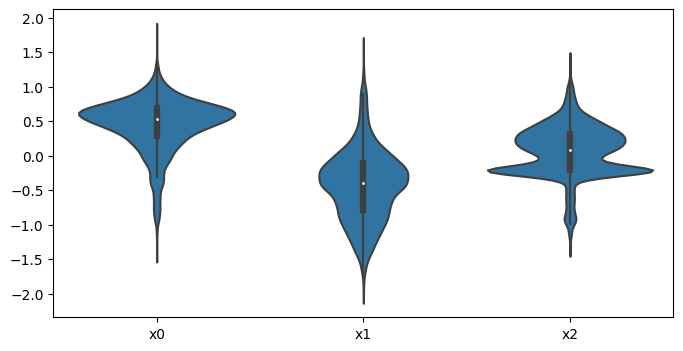

In [22]:
fig, ax = matplotlib.pyplot.subplots(figsize=FIGSIZE)

fg = seaborn.violinplot(data=df_incidents[feature_names], inner='box', color=seaborn.color_palette()[0])

fig.savefig('feature-distributions.pdf', dpi=600, bbox_inches='tight')

c:\Users\20173892\AppData\Local\Programs\Python\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\20173892\AppData\Local\Programs\Python\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\20173892\AppData\Local\Programs\Python\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\20173892\AppData\Local\Programs\Python\venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated a

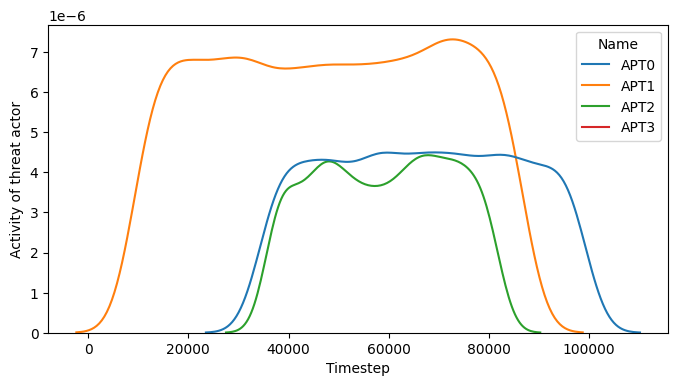

In [23]:
n_actors_shown = 4

shown_actors = [f'APT{i}' for i in range(n_actors_shown)]

fig, ax = matplotlib.pyplot.subplots(figsize=FIGSIZE)

fg = seaborn.kdeplot(
    data=df_incidents[df_incidents['Name'].apply(lambda x: x in shown_actors)],
    x='Timestep',
    hue="Name",
    hue_order=shown_actors,
)

fg.set_ylabel('Activity of threat actor')

fig.savefig('threat-actor-activity.pdf', dpi=600, bbox_inches='tight')

c:\Users\20173892\AppData\Local\Programs\Python\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\20173892\AppData\Local\Programs\Python\venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


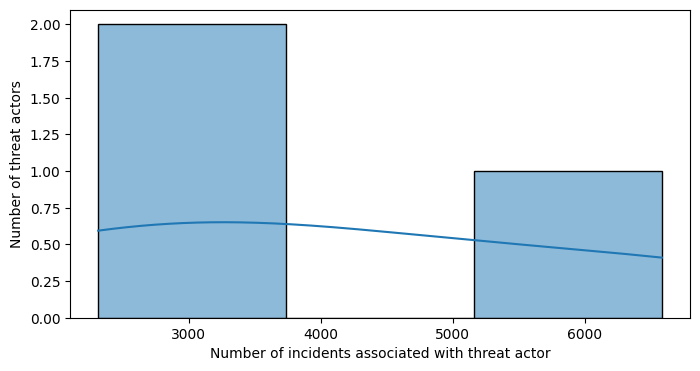

In [24]:
fig, ax = matplotlib.pyplot.subplots(figsize=FIGSIZE)

fg = seaborn.histplot(
    data=df_incidents['Name'].value_counts(), 
    kde=True,
)

fg.set_xlabel('Number of incidents associated with threat actor')
fg.set_ylabel('Number of threat actors')

fig.savefig('threat-actor-hist.pdf', dpi=600, bbox_inches='tight')

# Load/save dataset

In [25]:
df_incidents.to_csv('df_incidents_example.csv')

In [26]:
df_incidents = pandas.read_csv('df_incidents_example.csv')

# Split dataset

In [27]:
df_train = df_incidents[df_incidents['Timestep'] < EXPERIMENT_SIZE * TRAIN_SIZE]
df_test = df_incidents[df_incidents['Timestep'] >= EXPERIMENT_SIZE * TRAIN_SIZE]

len(df_train), len(df_test)

(4977, 7441)

In [28]:
df_train['Name'] = df_train['Name'].apply(lambda x: int(x[3:]))
df_test['Name'] = df_test['Name'].apply(lambda x: int(x[3:]))

C:\Users\20173892\AppData\Local\Temp\ipykernel_31012\4255208019.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['Name'] = df_train['Name'].apply(lambda x: int(x[3:]))
C:\Users\20173892\AppData\Local\Temp\ipykernel_31012\4255208019.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['Name'] = df_test['Name'].apply(lambda x: int(x[3:]))


## Run experiment

In [29]:
models = [
    copy.deepcopy(MODEL)
    for _ in range(FEATURES)
]

for i in tqdm.tqdm(range(FEATURES)):
    models[i].fit(df_train[[f'x{i}']].to_numpy(), df_train['Name'])

100%|██████████| 3/3 [00:04<00:00,  1.38s/it]


In [30]:
preds = []
for i in tqdm.tqdm(range(FEATURES)):
    preds.append(models[i].predict_proba(df_test[[f'x{i}']].to_numpy()))

100%|██████████| 3/3 [00:00<00:00,  5.38it/s]


In [31]:
pool_name = 'Pairing Aggregator'

incident_i = random.randint(0, len(df_test.index))
print(f'Using incident {incident_i} as an example.')

if not isinstance(df_test.iloc[incident_i]['Name'], str):
    apt_i = df_test.iloc[incident_i]['Name']
else:
    apt_i = int(df_test.iloc[incident_i]['Name'][3:])

print(f'According to the ground truth, this sample should be attributed to APT {apt_i}')

for j in range(FEATURES):
    print(f'Prediction for feature {j} is given by: ')
    print(preds[j][i])
    print(f'Based on this prediction, the incident would be attributed to APT {numpy.argmax(preds[j][i])}')

X = numpy.array([preds[j][i] for j in range(FEATURES)])
Y = []

for i in range(X.shape[0]):
    for j in range(i+1, X.shape[0]):
        c = logarithmic_opinion_pool(numpy.array([X[i, :], X[j, :]]))
        Y.append(c)
        
        print(f'Combining predictions for features {i} and {j} with the logarithmic opinion pool results in: ')
        print(c)
        print(f'Based on this prediction, the incident would be attributed to APT {numpy.argmax(c)}')

Y = numpy.array(Y)

c = linear_opinion_pool(Y)
        
print(f'Combining intermediate results from the pairs with the linear opinion pool results in: ')
print(c)
print(f'Based on this prediction, the incident would be attributed to APT {numpy.argmax(c)}')

Using incident 689 as an example.
According to the ground truth, this sample should be attributed to APT 2
Prediction for feature 0 is given by: 
[0.01322612 0.46335697 0.52341691]
Based on this prediction, the incident would be attributed to APT 2
Prediction for feature 1 is given by: 
[0.02995507 0.82382383 0.14622111]
Based on this prediction, the incident would be attributed to APT 1
Prediction for feature 2 is given by: 
[0.48338059 0.02436817 0.49225124]
Based on this prediction, the incident would be attributed to APT 2
Combining predictions for features 0 and 1 with the logarithmic opinion pool results in: 
[0.00086381 0.83226883 0.16686736]
Based on this prediction, the incident would be attributed to APT 1
Combining predictions for features 0 and 2 with the logarithmic opinion pool results in: 
[0.02321972 0.04100851 0.93577177]
Based on this prediction, the incident would be attributed to APT 2
Combining predictions for features 1 and 2 with the logarithmic opinion pool resu